<a href="https://colab.research.google.com/github/ActiveStacks/AI_with_PyTorch/blob/main/Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
path = ('/content/drive/MyDrive/XSS_dataset.csv')

In [4]:
df = pd.read_csv(path)

In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

<Axes: >

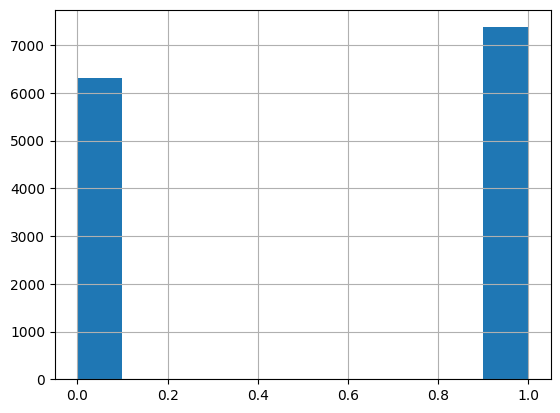

In [6]:
df['Label'].hist()

In [7]:
df.shape

(13686, 2)

In [8]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [9]:
df.columns = ['codes', 'label']
df.to_csv('XSS_processed_dataset.csv', index=False)

In [ ]:
!pip install datasets

In [11]:
from datasets import load_dataset

In [12]:
codes_dataset = load_dataset('csv', data_files='XSS_processed_dataset.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
codes_dataset

DatasetDict({
    train: Dataset({
        features: ['codes', 'label'],
        num_rows: 13686
    })
})

In [14]:
from posixpath import split
split_dataset = codes_dataset['train'].train_test_split(test_size=0.2)

In [15]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['codes', 'label'],
        num_rows: 10948
    })
    test: Dataset({
        features: ['codes', 'label'],
        num_rows: 2738
    })
})

In [16]:
from transformers import AutoTokenizer
checkpoint = 'microsoft/codebert-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [17]:
def tokenize_function(sets):
  return tokenizer(sets['codes'], truncation=True)

In [18]:
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10948 [00:00<?, ? examples/s]

Map:   0%|          | 0/2738 [00:00<?, ? examples/s]

In [19]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
!pip install torchinfo

In [21]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   38,603,520
│    │    └─Embedding: 3-2                                   394,752
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           1,538
To

In [22]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc= np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1': f1}

In [24]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_datasets['train'],
                  eval_dataset=tokenized_datasets['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss


NameError: name 'eval_pred' is not defined